In [1]:
from network import scGen
import scanpy.api as sc
sc.settings.verbosity = 0
import numpy as np
import wget

In [2]:
path_to_save = "../results"
sc.settings.figdir = path_to_save

URL for downloading train and validation data for Kang et al. dataset

In [3]:
train_url = "https://drive.google.com/uc?export=download&id=1-RpxbXwXEJLYZDFSHnWYenojZ8TxRZsP"
validation_url = "https://drive.google.com/uc?export=download&id=1h4E97Ymvb2LMNOfsSjSzLNbzT1OfuCy6"
t = wget.download(train_url, "../data/train_kang.h5ad")
v = wget.download(validation_url, "../data/valid_kang.h5ad")


Reading train and validation data

In [4]:
train =  sc.read("../data/train_kang.h5ad")
validation = sc.read("../data/valid_kang.h5ad")
#training cells
c_in = ['CD8T','NK','B','Dendritic', 'FCGR3A+Mono','CD14+Mono']
#heldout cells
c_out = [ 'CD4T']


Lets now make scGen object with training, validation and condition labels with training and held out cells

In [5]:
scg = scGen(train,validation,{"ctrl":"control", "stim":"stimulated"}, c_in, c_out,
           model_path="../models/scGen_Kang")

We train the model for 150 epochs 

In [6]:
scg.train(150)


----Training----
Model saved in file: ./models/scGen_Kang
Training finished


Making the prediction for CD4T cells




In [7]:
pred, delta = scg.predict('CD4T')


Extracting both control CD4T  cells from the data

In [8]:
adata_list = scg.dr.extractor(train,"CD4T")

Applying the Differential test to find out the genes differentially expressed after
the stimulation with IFN-beta

In [9]:
sc.tl.rank_genes_groups(adata_list[3], groupby="condition")

Extracting top 5 DE genes between control and stimulated CD4T cells

In [10]:
gene_list = adata_list[3].uns['rank_genes_groups']['names']["stimulated"].tolist()[0:5]

Making one single adata object that contains control, real and predicted CD4T cells 

In [11]:
all_Data = sc.AnnData(np.concatenate([adata_list[1].X.A, adata_list[2].X.A,pred]),)
all_Data.obs["condition"] = ["ctrl"] * len(adata_list[1].X.A) + ["real_stim"] * len(adata_list[2].X.A) + \
                            ["pred_stim"] * len( pred)
all_Data.var_names = adata_list[3].var_names

Comparing average expression of predcited, real and control cells over all genes for CD4T cells while labeling top 5 DE genes 


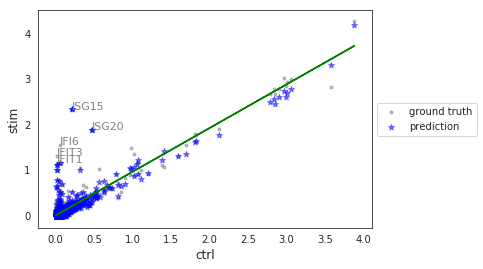

In [12]:
scg.dr.reg_overlap_plot(all_Data,gene_list,
                       path_to_save, "scGen_kang")

Variance and mean matching plots 

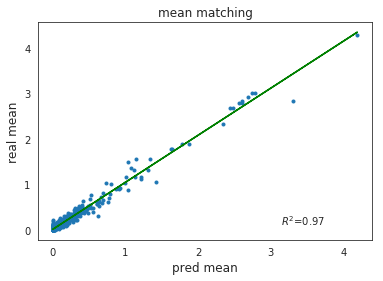

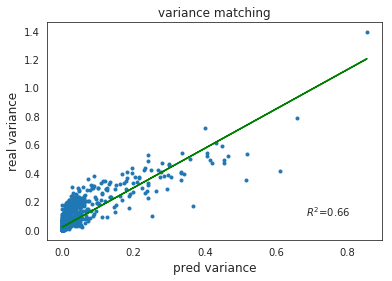

In [13]:
scg.dr.reg_mean_plot(all_Data, "../results/", "scGen_kang")
scg.dr.reg_var_plot(all_Data, "../results/", "scGen_kang")

Violin plot for top DE gene, "ISG15" comparing control, real and predicted CD4T cells

... storing 'condition' as categorical


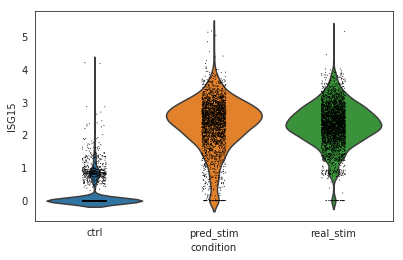

In [14]:
sc.pl.violin(all_Data, groupby="condition", keys="ISG15", save="_ISG15_scGen_kang.pdf")

Now, we visualize control, real and predicted CD4T cells using UMAP 

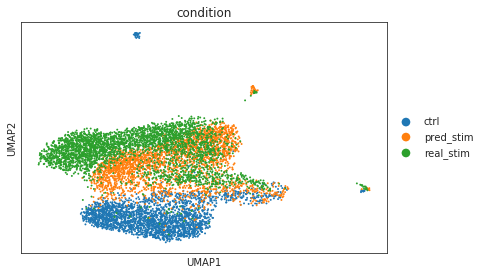

In [15]:
sc.pp.neighbors(all_Data)
sc.tl.umap(all_Data)
sc.pl.umap(all_Data, color = ["condition"],  save="_scGen_kang.pdf")

now we interpolate 2000 intermediary cells between control and predicted CD4T cells and show how
top 5 DE  genes change as we move from control to predicted cells 

In [16]:
ctrl = all_Data[all_Data.obs["condition"] == "ctrl"].X
pred_stim = all_Data[all_Data.obs["condition"] == "pred_stim"].X
inter_cdm = sc.AnnData(scg.linear_interploation(ctrl,pred_stim,2000))
inter_cdm.var_names = train.var_names
all_Data = sc.AnnData(np.concatenate([adata_list[1].X.A, pred_stim,inter_cdm.X]),)
all_Data.obs["condition"] = ["ctrl"] * len(adata_list[1].X.A) + ["pred_stim"] * len(pred_stim) + \
                            ["intermediate"] * len( inter_cdm)
all_Data.var_names = adata_list[3].var_names

... storing 'condition' as categorical


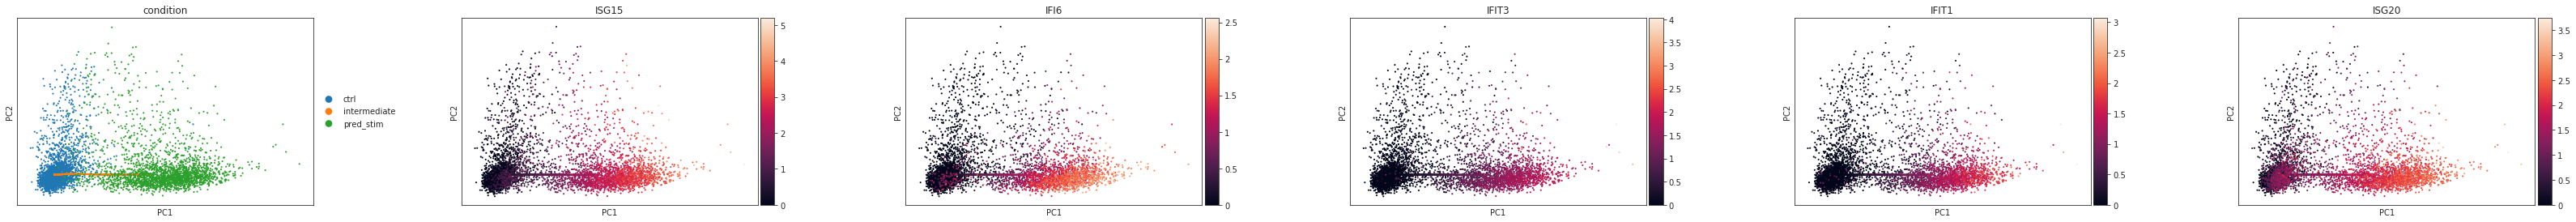

In [17]:
sc.tl.pca(all_Data)
to_show  =  ["condition"] + gene_list
sc.pl.pca(all_Data, color=to_show)


The Latent space representation which for the training data still pereserve
both condition and cell type information 

... storing 'cell_type' as categorical
... storing 'condition' as categorical


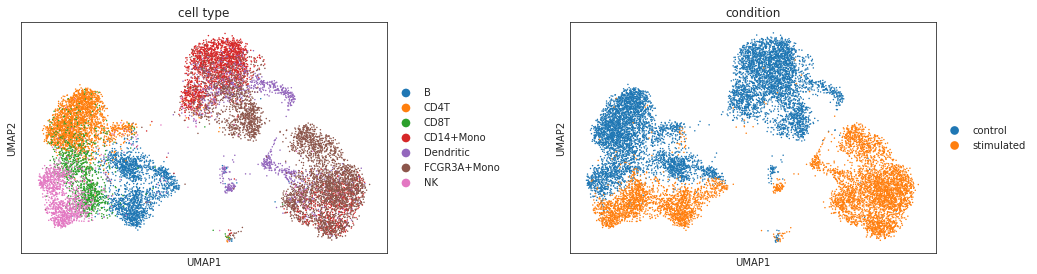

In [18]:
low_dim = scg._to_latent(scg.dr.train_real_adata.X)
dt = sc.AnnData(low_dim)
sc.pp.neighbors(dt)
sc.tl.umap(dt)
dt.obs["cell_type"] = scg.dr.train_real_adata.obs["cell_type"]
dt.obs["condition"] = scg.dr.train_real_adata.obs["condition"]
sc.pl.umap(dt, color=["cell_type", "condition"], save="_scg_latent.pdf")



Building a classifier using dot-product results as explained in the paper

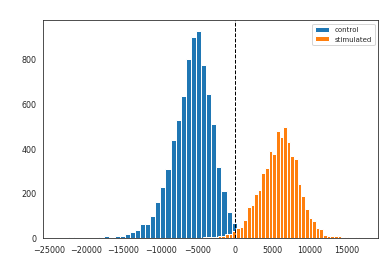

In [19]:
scg.dr.dpclassifier_hist(scg, scg.dr.train_real_adata, delta, "../results/dot_classifier_kang.pdf")